**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
- [Problématique](#toc2_)    
  - [Modèle précédent](#toc2_1_)    
  - [Améliorations](#toc2_2_)    
- [Jeux de données](#toc3_)    
  - [Données brutes](#toc3_1_)    
  - [Pré-traitement des données](#toc3_2_)    
- [Modèle](#toc4_)    
  - [Configuration](#toc4_1_)    
  - [Définition du modèle](#toc4_2_)    
  - [Compilation](#toc4_3_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc5_)    
  - [Entraînement](#toc5_1_)    
- [Conclusion](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
import os
import yaml
import shutil
import logging

# DS, ML & DL
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import Model
from keras_cv.models import YOLOV8Detector
from keras.utils import image_dataset_from_directory
from keras.layers import Flatten, Dense, Resizing
from keras.optimizers import AdamW

# images & data viz
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# home made functions from src folder
from src.data import extract_data, create_img_db
from src.data import create_annot, copy_images
from src.models import eval_model, ConditionalAugmentation

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

2024-08-30 17:16:59.234010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 17:16:59.253047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 17:16:59.275124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 17:16:59.280042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 17:16:59.294751: I tensorflow/core/platform/cpu_feature_guar

Configuration

In [2]:
# local config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# load data
RAW_DATA_URI = cfg["data"]["raw_data_uri"]
DATA_DIR = cfg["data"]["local_path"]
IMG_DIR = os.path.join(DATA_DIR, cfg["data"]["img_dir"])
ANNOT_DIR = os.path.join(DATA_DIR, cfg["data"]["annot_dir"])
IMG_DB_URI = os.path.join(DATA_DIR, cfg["data"]["img_db_uri"])

# for models
CLASSES = cfg["models"]["classes"]
CHKPT_DIR = os.path.join(DATA_DIR, cfg["data"]["checkpoint_dir"])
LOG_DIR = cfg["log"]["log_dir"]

Images et annotations, création de la BDD

In [3]:
if os.path.exists(IMG_DB_URI):
    img_df = pd.read_csv(IMG_DB_URI, index_col=0)
else:
    # extract data
    print("⚙️ Extracting data...")
    extract_data(RAW_DATA_URI, DATA_DIR)
    
    # create database
    print("⚙️ Creating database...")
    img_df = create_img_db(IMG_DIR, ANNOT_DIR, IMG_DB_URI)

# <a id='toc2_'></a>[Problématique](#toc0_)

## <a id='toc2_1_'></a>[Modèle précédent](#toc0_)

Précédemment, le modèle EfficientNet_B0 pré-entraîné avait été ajusté (extraction de caractéristiques seules) pour détecter 10 races de chiens (classification).  
Il a donné de très bons résultats tant à l'entraînement qu'en production :

<img src="outputs/EfficientNetB0_10/EfficientNetB0_10_cmtx.png" height="400px">
<img src="outputs/EfficientNetB0_10/EfficientNetB0_10_metric.png" height="400px">
<img src="outputs/EfficientNetB0_10/EfficientNetB0_10_loss.png" height="400px">

## <a id='toc2_2_'></a>[Améliorations](#toc0_)

Cela a cependant des limites, comme le fait qu'on ait **parfois plusieurs chiens sur une seule image**, que ce soit dans le jeu de données d'entraînement mais surtout dans l'application concrète du modèle avec des particuliers qui envoient des photos de leur(s) chien(s) à une association.

Ainsi, il serait préférable d'avoir un outil permettant de **détecter directement les chiens présents sur les photos**, peu importe le nombre.  
Toutefois, une **segmentation précise n'est pas nécessaire**, la **détection par boîtes** suffirait pour le cas d'usage.

Il est donc nécessaire de trouver un modèle aussi efficace sur la détection d'un ou plusieurs chiens.

# <a id='toc3_'></a>[Jeux de données](#toc0_)

## <a id='toc3_1_'></a>[Données brutes](#toc0_)

Vérification des classes et visualisation d'exemples

1754 images, 10 features
175.4 images per class, 447.0 avg width, 384.0 avg height


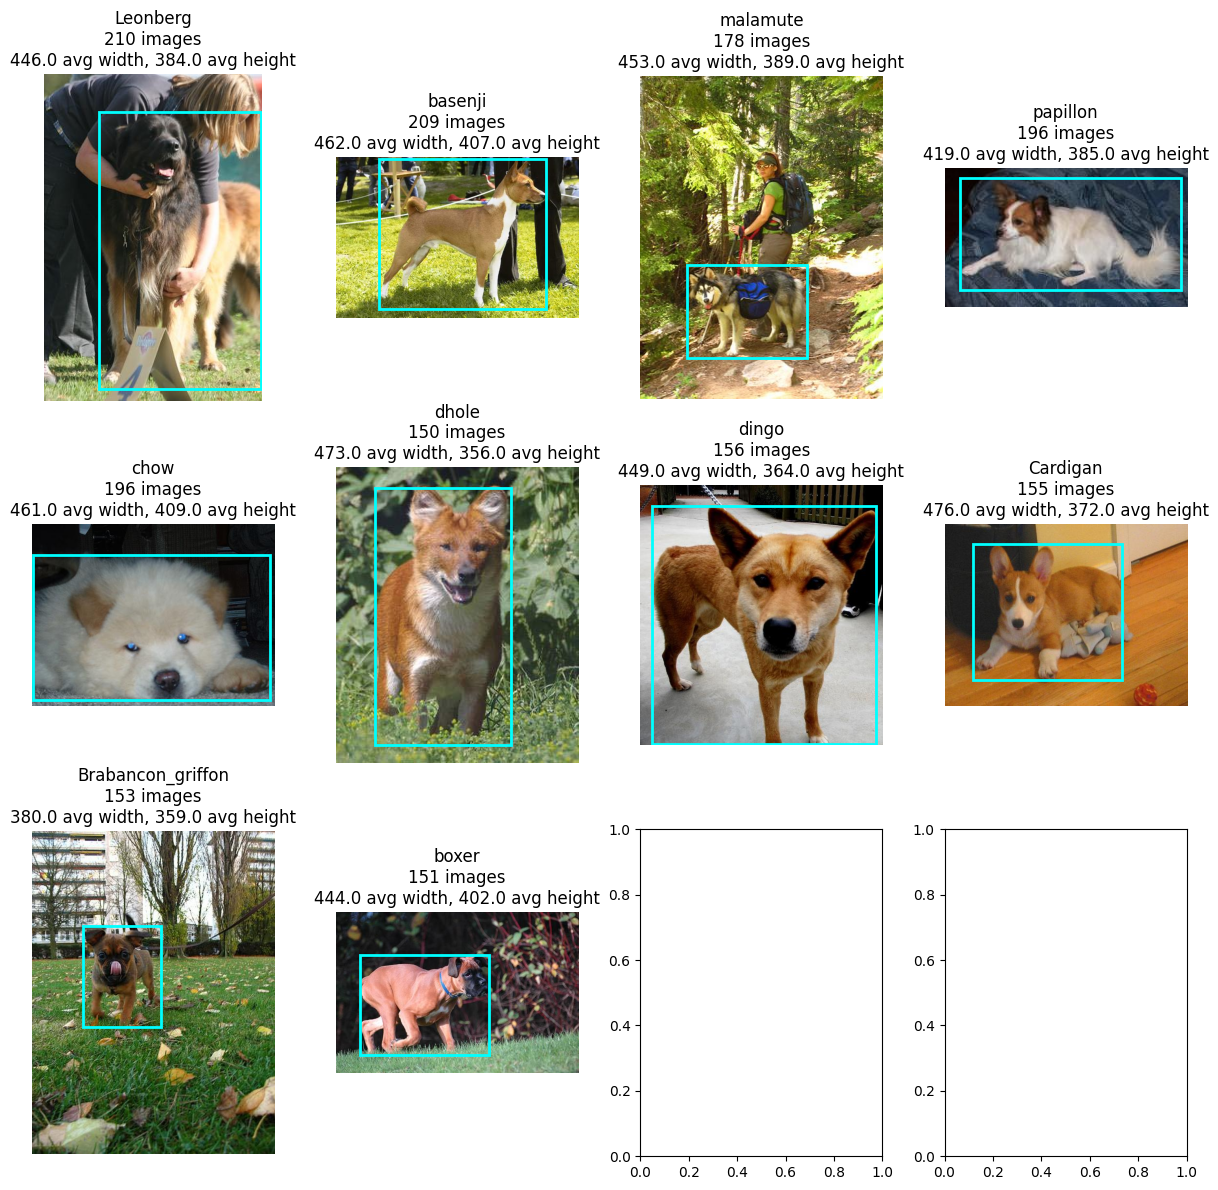

In [4]:
m_n_img = img_df["class_label"].value_counts().values.mean()
m_w = img_df["width"].mean().round(0)
m_h = img_df["height"].mean().round(0)

print(f"{img_df.shape[0]} images, {img_df.shape[1]} features")
print(f"{m_n_img} images per class, {m_w} avg width, {m_h} avg height")

rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))

for i, c in enumerate(CLASSES):
    _ = img_df.loc[img_df["class_label"] == c]

    # n images
    n_img = _["ID"].nunique()
    # mean width
    m_w = _["width"].mean().round(0)
    # mean height
    m_h = _["height"].mean().round(0)

    # pick image
    img = Image.open(_["img_uri"].to_list()[0])

    # get bounding box
    bb_xmin = _["bb_xmin"].to_list()[0]
    bb_ymin = _["bb_ymin"].to_list()[0]
    bb_xmax = _["bb_xmax"].to_list()[0]
    bb_ymax = _["bb_ymax"].to_list()[0]
    width = bb_xmax - bb_xmin
    height = bb_ymax - bb_ymin

    # display
    row = i // cols
    col = i % cols
    axs[row][col].imshow(img)
    axs[row][col].add_patch(
        patches.Rectangle((bb_xmin, bb_ymin), width, height, linewidth=2, edgecolor='cyan', facecolor='none')
    )
    axs[row][col].axis("off")
    axs[row][col].set_title(f"{c}\n{n_img} images\n{m_w} avg width, {m_h} avg height")

plt.tight_layout()
plt.show()
plt.close()

## <a id='toc3_2_'></a>[Pré-traitement des données](#toc0_)

Encodage des classes

In [5]:
img_df['class_enc'] = img_df['class_label'].apply(lambda x: CLASSES.index(x))

Création du fichier de configuration

In [6]:
with open(os.path.join(DATA_DIR, "data.yaml"), 'w') as f:
    f.write(f'path: {os.path.join(".", DATA_DIR)}\n')
    f.write(f'train: {os.path.join("images", "train")}\n')
    f.write(f'val: {os.path.join("images", "val")}\n')
    f.write(f'test: {os.path.join("images", "test")}\n')
    f.write(f'nc: {len(CLASSES)}\n')
    f.write(f'names: {CLASSES}')

Séparation des données

In [7]:
# data split
train_val, test = train_test_split(
    img_df, test_size=0.1, stratify=img_df["class_enc"], random_state=42
)
train, val = train_test_split(
    train_val, test_size=0.2, stratify=train_val["class_enc"], random_state=42
)

print(f"Train set: {train.shape[0]} images")
print(f"Validation set: {val.shape[0]} images")
print(f"Test set: {test.shape[0]} images")


Train set: 1262 images
Validation set: 316 images
Test set: 176 images


Création des annotations au format du modèle et copie des images selon les séparations des jeux de données

In [10]:
# train
_ = train.apply(lambda x: create_annot(x, DATA_DIR, "train"), axis=1)
_ = train.apply(lambda x: copy_images(x, DATA_DIR, "train"), axis=1)

# val
_ = val.apply(lambda x: create_annot(x, DATA_DIR, "val"), axis=1)
_ = val.apply(lambda x: copy_images(x, DATA_DIR, "val"), axis=1)

# test
_ = test.apply(lambda x: create_annot(x, DATA_DIR, "test"), axis=1)
_ = test.apply(lambda x: copy_images(x, DATA_DIR, "test"), axis=1)

# <a id='toc4_'></a>[Modèle](#toc0_)

## <a id='toc4_1_'></a>[Configuration](#toc0_)

In [16]:
input_size = (224, 224)
batch_size = 48
n_epochs = 100
optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
classif_loss = "binary_crossentropy"
classif_metric = "accuracy"
bbox_loss_loss='mean_squared_error'
bbox_metric = tf.keras.metrics.MeanIoU(num_classes=10)
# classif_loss = "sparse_categorical_crossentropy"
# bbox_metric = "mse"

## <a id='toc4_2_'></a>[Définition du modèle](#toc0_)

In [13]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View settings with 'yolo settings' or at '/home/jl/.config/Ultralytics/settings.yaml'
Update settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:02<00:00, 9.84MB/s]


# <a id='toc5_'></a>[🦄🦄 CHECKPOINT 🦄🦄](#toc0_)

- revoir .yaml : ERREUR
``` bash
 FileNotFoundError: Dataset 'data/data.yaml' images not found ⚠️, missing path '/home/jl/projets/datasets/data/images/val'
```

In [15]:
results = model.train(
    name='dog_breeds',
    data='data/data.yaml',
    epochs=n_epochs,
    imgsz=input_size[0],
    batch=batch_size,
    device='cpu',
    project='runs/train',
    exist_ok=True,  # Écraser les résultats existants
    pretrained=True,  # Utiliser les poids pré-entraînés
    augment=True,  # Activer l'augmentation des données
    save=True,
    # save_period=1,  # Sauvegarder le modèle à chaque époque
)


Ultralytics YOLOv8.2.84 🚀 Python-3.11.6 torch-2.0.1+cu117 CPU (11th Gen Intel Core(TM) i5-1145G7 2.60GHz)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data/data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=runs/train, name=dog_breeds, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

RuntimeError: Dataset 'data/data.yaml' error ❌ 
Dataset 'data/data.yaml' images not found ⚠️, missing path '/home/jl/projets/datasets/data/images/val'
Note dataset download directory is '/home/jl/projets/datasets'. You can update this in '/home/jl/.config/Ultralytics/settings.yaml'

In [11]:
stop

NameError: name 'stop' is not defined

In [ ]:
model_name = "YOLOv8_EffNetB0"

model = YOLOV8Detector.from_preset(
    "efficientnetv2_b0_imagenet",
    load_weights=True,
    num_classes=10,
    bounding_box_format="xyxy",
)

# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# resize images
resized = Resizing(input_size[0], input_size[1])(inputs)
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(resized)
x = model(augmented)

# for feature extraction only
for layer in model.layers:
    layer.trainable = False

# outputs treatment
bbox_out = x['boxes']
class_out = x['classes']

# flatten outputs
# c = Flatten()(class_out)
# bb = Flatten()(bbox_out)

# new FC layer for 10 classes classification
bbox_preds = Dense(4, activation="linear")(bbox_out)
class_preds = Dense(10, activation="sigmoid")(class_out)

# define new model
yolo = Model(inputs=inputs, outputs=[bbox_preds, class_preds])
# display model summary
yolo.summary()

/home/jl/projets/oc_p7/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing (Resizing) │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conditional_augmen… │ (None, 224, 224,  │          0 │ resizing[0][0]    │
│ (ConditionalAugmen… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yolov8_detector     │ [(None, 1029,     │ 28,006,350 │ conditional_augm… │
│ (YOLOV8Detector)    │ 64), (None, 1029, │            │                   │
│                     │ 10)]              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1029, 4)   │        260 │ yolov8_detector[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1029, 10)  │        110 │ yolov8_detector[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,006,720 (106.84 MB)

 Trainable params: 370 (1.45 KB)

 Non-trainable params: 28,006,350 (106.84 MB)

## <a id='toc4_3_'></a>[Compilation](#toc0_)

In [ ]:
yolo.compile(
    optimizer=optimizer,
    loss={'class_preds': classif_loss, 'bbox_preds': bbox_loss_loss},
    metrics={'class_preds': classif_metric, 'bbox_preds': bbox_metric},
)

## <a id='toc5_1_'></a>[Entraînement](#toc0_)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# data augmentation and shuffle
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

# generate data
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(256, 256),  # Correspond à la taille d'entrée du modèle
    batch_size=32,
    class_mode=None
)  # Pas de class_mode pour multi-label

In [ ]:
# Entraînement du modèle
fine_tuned_model.fit(
    x=X_train,
    y={'class_predictions': y_train_classes, 'bounding_box_predictions': y_train_boxes},
    validation_data=(X_val, {'class_predictions': y_val_classes, 'bounding_box_predictions': y_val_boxes}),
    batch_size=batch_size,
    epochs=50,
)

🚧 inférence ?

``` python
# Charger le meilleur modèle
model = YOLO('runs/train/dog_breeds/weights/best.pt')

# Effectuer une inférence sur une nouvelle image
results = model.predict('path/to/new/image.jpg')

# Afficher les résultats
for result in results:
    result.show()  # Affiche l'image avec les boîtes englobantes
```

➡️ Commentaires
- le temps d'entraînement est très court par rapport au nombre de classes à apprendre
- ce modèle est très performant, avec des erreurs peu nombreuses et localisées majoritairement sur une classe
- un très bon compromis ressources / performances

# <a id='toc6_'></a>[Conclusion](#toc0_)

Les différents modèles testés montrent bien leurs différences lors de l'entraînement, même avec peu de classes à apprendre et des hyperparamètres similaires.

**EfficientNet a montré d'excellentes capacités**, même dans sa version minimale, tant pour 3 que pour 10 classes et sa relative légèreté (< 18Mo de paramètres) en fait un modèle de choix à implémenter dans l'application métier répondant à la problématique de cet exercice.